In [1]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable           Type              Data/Info
----------------------------------------------
Tsam               float64           0.5
dvMathcalP         LinearIOSystem    <LinearIOSystem>: sys[115<...>[[0. 0.]\n     [0. 0.]]\n
extMathcalP        LinearIOSystem    <LinearIOSystem>: sys[114<...> [0. 0.]\n     [0. 0.]]\n
fullOrder          int               100
hsvDvMathcalP      ndarray           100: 100 elems, type `float64`, 800 bytes
hsvExtMathcalP     ndarray           100: 100 elems, type `float64`, 800 bytes
mathcalC           StateSpace        A = [[-100.]]\n\nB = [[10<...>]]\n\nD = [[0.1008991]]\n
mathcalP_cb        LinearIOSystem    <LinearIOSystem>: sys[6]\<...>[[0. 0.]\n     [0. 0.]]\n
overlineMathcalC   StateSpace        A = [[0.]]\n\nB = [[0.1]]<...>0.1008991]]\n\ndt = 0.5\n
reducOrder         int               8
truncDvMathcalP    LinearIOSystem    <LinearIOSystem>: sys[117<...>[[0. 0.]\n     [0. 0.]]\n
truncExtMathcalP   LinearIOSystem    <LinearIOSystem>: sys[116<...> [

In [2]:
import numpy
import sympy
import scipy
import control
import matplotlib as mpl
import matplotlib.pyplot as plt

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 } )
%matplotlib inline

In [3]:
# Loop parameters
kp_lims = [1, 10]
kp_steps = 5
kps = numpy.linspace(kp_lims[0],kp_lims[1],kp_steps)

samp_lim = [0.05,0.5]
samp_steps = 5
samplings = numpy.linspace(samp_lim[0],samp_lim[1],samp_steps)

In [5]:
#Create plot
 
s = control.TransferFunction.s
small_gain_FOM = numpy.empty((samp_steps,kp_steps))*0
small_gain_ROM = numpy.empty((samp_steps,kp_steps))*0

for i in range(samp_steps):
    
    # if(i>0 and small_gain_FOM[i-1][-1]>=1):
    #     for j in range(wn_steps):
    #         small_gain_FOM[i,j]=1
    #         small_gain_ROM[i,j]=1
    #     continue
    
    for j in range(kp_steps):
        Tsam = samplings[i]
        kp = kps[j]
        #######################################################################
        # Create notch filter
        ti=0.1
        num = [kp*ti,kp]
        den = [ti,0]
        mathcalC = control.tf2ss(num,den)
        #######################################################################
        # Norm operator Delta
        normInfDelta = 2*Tsam/numpy.pi
        # Discretizing controller and computing norm of widetildeMathcalCs
        overlineMathcalC = control.sample_system(mathcalC, Tsam, 'zoh')
        mathcalCPrime = control.ss(mathcalC.A,mathcalC.B,mathcalC.C,numpy.zeros(mathcalC.D.shape))
        tfMathcalCPrime = control.ss2tf(mathcalCPrime)
        normInfWidetildeMathcalCs = normInfDelta * ControlUtils.hinfnorm(mathcalC) \
                                + normInfDelta * ControlUtils.hinfnorm(s * tfMathcalCPrime) * normInfDelta \
                                + ControlUtils.hinfnorm(tfMathcalCPrime) * normInfDelta 
        #######################################################################                        
        # Creating closed-loop
        # Controller matrices
        Ac = mathcalC.A
        Bv = mathcalC.B
        Cw = mathcalC.C
        Dw = mathcalC.D
        #######################################################################
        # FOM extended plant
        Ap = extMathcalP.A
        Bw = extMathcalP.B[:,0:1]
        Bu = extMathcalP.B[:,1:2]
        Cv = extMathcalP.C[0:1,:]
        Cy = extMathcalP.C[-1:,:]
        Dv = extMathcalP.D[0:1,:]
        Dy = extMathcalP.D[-1:,:]
        # Closed-loop with FOM Extended Plant
        extAcl = numpy.row_stack( [ numpy.column_stack( [ Ap + Bw@Dw@Cv, Bw@Cw ] ),
                                    numpy.column_stack( [ Bv@Cv, Ac ] )
                                    ] )
        extBcl = numpy.row_stack( [ numpy.column_stack([Bw, Bu]),
                                    numpy.column_stack( [ numpy.zeros( (Ac.shape[0],Bw.shape[1]) ), numpy.zeros( (Ac.shape[0],Bu.shape[1]) ) ] )
                                    ] )
        extCcl = numpy.row_stack( [ numpy.column_stack( [ Cv, numpy.zeros( (Cv.shape[0],Ac.shape[0]) ) ] ),
                                    numpy.column_stack( [ Cv@Ap + Cv@Bw@Dw@Cv, Cv@Bw@Cw ] ),
                                    numpy.column_stack( [ Cy, numpy.zeros( (Cy.shape[0],Ac.shape[0]) ) ] )
                                    ] )
        extDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (Cv.shape[0],Bw.shape[1]) ), numpy.zeros( (Cv.shape[0],Bu.shape[1]) ) ] ),
                                    numpy.column_stack( [ Cv@Bw , Cv@Bu] ),
                                    numpy.column_stack( [ numpy.zeros( (Cy.shape[0],Bw.shape[1]) ), numpy.zeros( (Cy.shape[0],Bu.shape[1]) ) ] )
                                    ] )
        extMathcalPcl = control.ss(extAcl,extBcl,extCcl,extDcl)
        #######################################################################
        # ROM extended plant
        truncExtAp = truncExtMathcalP.A
        truncExtBw = truncExtMathcalP.B[:,0:1]
        truncExtBu = truncExtMathcalP.B[:,1:2]
        truncExtCv = truncExtMathcalP.C[0:1,:]
        truncExtCy = truncExtMathcalP.C[-1:,:]
        truncExtDv = truncExtMathcalP.D[0:1,:]
        truncExtDy = truncExtMathcalP.D[-1:,:]
        # Closed-loop with ROM Extended Plant
        truncExtAcl = numpy.row_stack( [ numpy.column_stack( [ truncExtAp + truncExtBw@Dw@truncExtCv, truncExtBw@Cw ] ),
                                    numpy.column_stack( [ Bv@truncExtCv, Ac ] )
                                    ] )
        truncExtBcl = numpy.row_stack( [ numpy.column_stack([truncExtBw, truncExtBu]),
                                    numpy.column_stack( [ numpy.zeros( (Ac.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (Ac.shape[0],truncExtBu.shape[1]) ) ] )
                                    ] )
        truncExtCcl = numpy.row_stack( [ numpy.column_stack( [ truncExtCv, numpy.zeros( (truncExtCv.shape[0],Ac.shape[0]) ) ] ),
                                    numpy.column_stack( [ truncExtCv@truncExtAp + truncExtCv@truncExtBw@Dw@truncExtCv, truncExtCv@truncExtBw@Cw ] ),
                                    numpy.column_stack( [ truncExtCy, numpy.zeros( (truncExtCy.shape[0],Ac.shape[0]) ) ] )
                                    ] )
        truncExtDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (truncExtCv.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCv.shape[0],truncExtBu.shape[1]) ) ] ),
                                    numpy.column_stack( [ truncExtCv@truncExtBw , truncExtCv@truncExtBu] ),
                                    numpy.column_stack( [ numpy.zeros( (truncExtCy.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCy.shape[0],truncExtBu.shape[1]) ) ] )
                                    ] )
        truncExtMathcalPcl = control.ss(truncExtAcl,truncExtBcl,truncExtCcl,truncExtDcl)
        #######################################################################
        approxErrorExtMathcalPcl = extMathcalPcl-truncExtMathcalPcl
        # wLims = numpy.array([1e0, 1e8])
        # control.bode_plot(approxErrorExtMathcalPcl[0,0], omega_limits=wLims, deg=True, wrap_phase=True)
        # control.bode_plot(approxErrorExtMathcalPcl[1,0], omega_limits=wLims, deg=True, wrap_phase=True)
        # control.bode_plot(approxErrorExtMathcalPcl[2,0], omega_limits=wLims, deg=True, wrap_phase=True)
        # plt.show()
        #######################################################################
        # Computing norms for small-gain stability condition
        gamma_tildew_dv = ControlUtils.hinfnorm(extMathcalPcl[1,0])
        epsilon_tildew_dv = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[1,0])
        gamma_dv_tildew = normInfWidetildeMathcalCs
        print("gamma_tildew_dv: %5.5f, epsilon_tildew_dv: %5.5f, gamma_dv_tildew: %5.5f"%(gamma_tildew_dv,epsilon_tildew_dv,normInfWidetildeMathcalCs))
        #######################################################################
        small_gain_argument_FOM = gamma_tildew_dv*gamma_dv_tildew
        small_gain_FOM[i,j] = small_gain_argument_FOM    
        small_gain_argument_ROM = (gamma_tildew_dv+epsilon_tildew_dv)*gamma_dv_tildew
        small_gain_ROM[i,j] = small_gain_argument_ROM
        print("Small-gain condition. Tsam[%d]: %2.3f, kp[%d]: %3.5f, FOM: %2.5f, ROM: %2.5f"%(i,Tsam,j,kp,small_gain_argument_FOM,small_gain_argument_ROM))
        
        # if(small_gain_ROM[i,j]<1):
        #     break

gamma_tildew_dv: 0.35658, epsilon_tildew_dv: 0.00708, gamma_dv_tildew: 0.07786
Small-gain condition. Tsam[0]: 0.050, wn[0]: 1.00000, FOM: 0.02776, ROM: 0.02831
gamma_tildew_dv: 0.35695, epsilon_tildew_dv: 0.00708, gamma_dv_tildew: 0.25305
Small-gain condition. Tsam[0]: 0.050, wn[1]: 3.25000, FOM: 0.09033, ROM: 0.09212
gamma_tildew_dv: 0.35726, epsilon_tildew_dv: 0.00708, gamma_dv_tildew: 0.42823
Small-gain condition. Tsam[0]: 0.050, wn[2]: 5.50000, FOM: 0.15299, ROM: 0.15602
gamma_tildew_dv: 0.35749, epsilon_tildew_dv: 0.00708, gamma_dv_tildew: 0.60342
Small-gain condition. Tsam[0]: 0.050, wn[3]: 7.75000, FOM: 0.21572, ROM: 0.21999
gamma_tildew_dv: 0.35766, epsilon_tildew_dv: 0.00708, gamma_dv_tildew: 0.77860
Small-gain condition. Tsam[0]: 0.050, wn[4]: 10.00000, FOM: 0.27848, ROM: 0.28399
gamma_tildew_dv: 0.35658, epsilon_tildew_dv: 0.00708, gamma_dv_tildew: 0.26045
Small-gain condition. Tsam[1]: 0.163, wn[0]: 1.00000, FOM: 0.09287, ROM: 0.09472
gamma_tildew_dv: 0.35695, epsilon_tilde

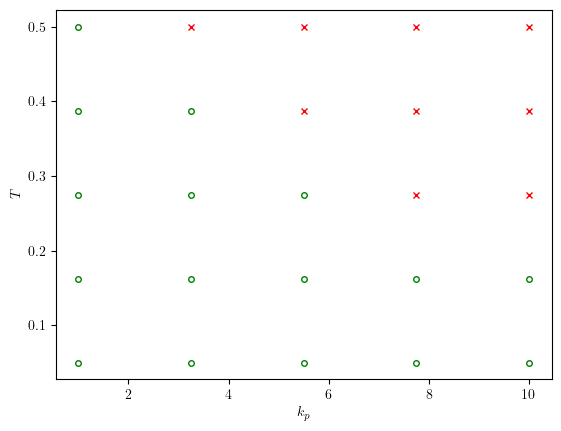

In [7]:
for i in range(samp_steps):
    for j in range(kp_steps):
        Tsam = samplings[i]
        wn = kps[j]
        
        if(small_gain_FOM[i,j]>=1):
            plt.plot(wn, Tsam, marker="x", markersize=4, markerfacecolor='r', markeredgecolor='r')
        elif(small_gain_ROM[i,j]>=1):
            plt.plot(wn, Tsam, marker="x", markersize=4, markerfacecolor='b', markeredgecolor='b')
        else:
            plt.plot(wn, Tsam, marker="o", markersize=4, markerfacecolor='none', markeredgecolor='g')
            
        # if(small_gain_FOM[i,j]<1 and small_gain_ROM[i,j]>1):
        #     plt.plot(cutoff, Tsam, marker="x", markersize=4, markerfacecolor='b', markeredgecolor='b')
        #     # plt.plot(cutoff, Tsam, marker="o", markersize=7, markerfacecolor='none', markeredgecolor='b')
        # else:
        #     if(small_gain_ROM[i,j]<1):
        #         plt.plot(cutoff, Tsam, marker="o", markersize=4, markerfacecolor='b', markeredgecolor='g')
        #     else:
        #         # plt.plot(cutoff, Tsam, marker="x", markersize=4, markerfacecolor='r', markeredgecolor='r')
        #         if(small_gain_FOM[i,j]<1):
        #             plt.plot(cutoff, Tsam, marker="o", markersize=7, markerfacecolor='none', markeredgecolor='g')
        #         else:
        #             plt.plot(cutoff, Tsam, marker="o", markersize=7, markerfacecolor='none', markeredgecolor='r')
            
plt.ylabel('$T$')
plt.xlabel('$k_p$')
plt.show()

In [ ]:
%store -d mathcalC overlineMathcalC Tsam
%store mathcalC overlineMathcalC Tsam

Stored 'mathcalC' (StateSpace)
Stored 'overlineMathcalC' (StateSpace)
Stored 'Tsam' (float64)
